<a href="https://colab.research.google.com/github/AlexandraMikheeva/Generative-Adversarial-Network/blob/main/Build_a_Generative_Adversarial_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with PyTorch : Build a Generative Adversarial Network

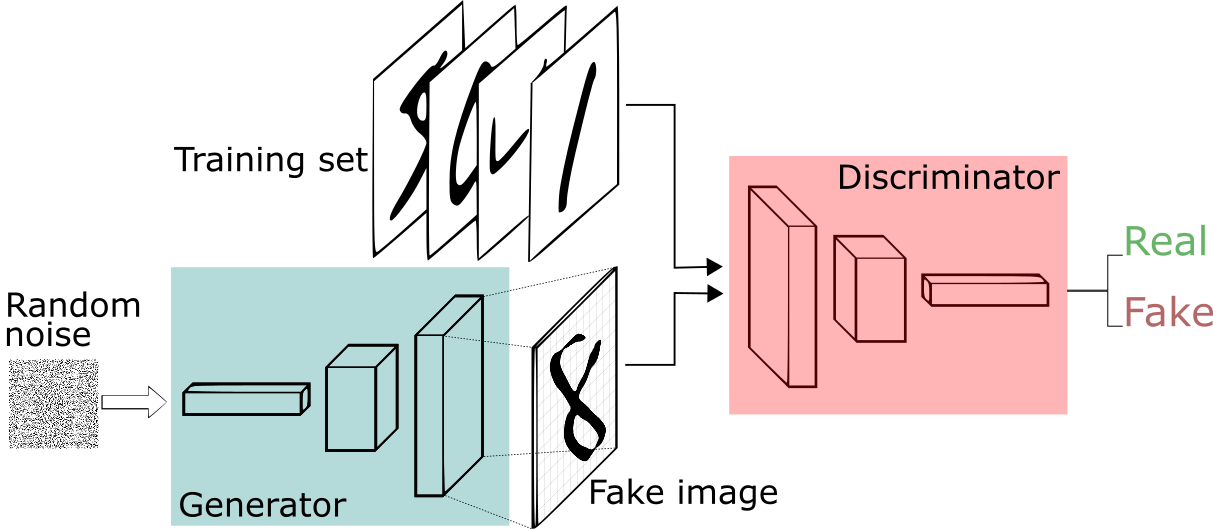

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [20]:
device = 'cuda'

batch_size = 128

noise_dim = 64

# optimizers parameters

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables

epochs = 20

# Load MNIST Dataset

In [5]:
from torchvision import datasets, transforms as T

In [7]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor() # (h, w, c) -> (c, h, w)
])

In [10]:
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

100%|██████████| 9912422/9912422 [00:00<00:00, 113661607.90it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 88098686.42it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26886544.45it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20528587.03it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



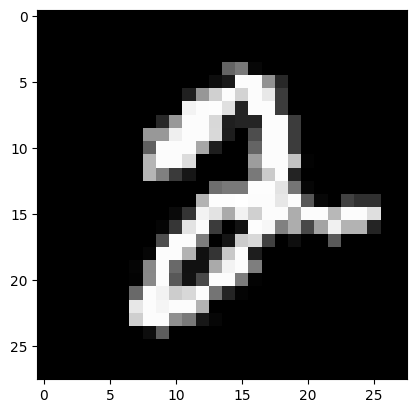

In [12]:
image, label = trainset[5]

plt.imshow(image.squeeze(), cmap='gray')

In [13]:
len(trainset)

60000

In [14]:

label

2

# Load Dataset Into Batches

In [17]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [27]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [28]:
print(len(trainloader)) # num of batches

469


In [37]:
dataiter = iter(trainloader)

images, _ = next(dataiter)

print(images.shape)

torch.Size([128, 1, 28, 28])


In [60]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

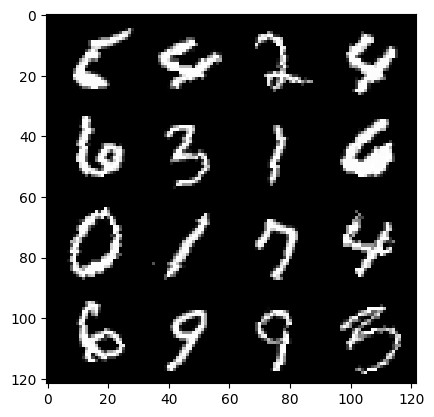

In [61]:
show_tensor_images(images, num_images=16)

In [42]:
# import torch

# # Create a tensor with requires_grad=True
# tensor = torch.tensor([1.0], requires_grad=True)
# print("Original Tensor:", tensor)

# # Perform some operation
# result = tensor * 2
# print("Original Tensor:", tensor)
# print("result:", result)

# # Detach the result tensor from the computation graph
# detached_result = result.detach()
# print("Original Tensor:", tensor)
# print("Detached Tensor:", detached_result)

# # Modify the detached_result (won't affect the original tensor)
# detached_result *= 2
# print("Original Tensor:", tensor)
# print("result:", result)
# print("Detached Tensor:", detached_result)


# # Print the original tensor and detached tensor
# # print("Original Tensor:", tensor)


Original Tensor: tensor([1.], requires_grad=True)
Original Tensor: tensor([1.], requires_grad=True)
result: tensor([2.], grad_fn=<MulBackward0>)
Original Tensor: tensor([1.], requires_grad=True)
Detached Tensor: tensor([2.])
Original Tensor: tensor([1.], requires_grad=True)
result: tensor([4.], grad_fn=<MulBackward0>)
Detached Tensor: tensor([4.])


# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

# Create Loss Function and Load Optimizer

# Training Loop

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya